In [1]:
import os
import shutil

import numpy as np

from IPython.display import clear_output


run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)))

Содержимое директории /Users/adzhumurat/PycharmProjects/ai_product_engineer/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data', 'content_catalog.zip', 'user_item_views.zip', 'pipelines-data', 'zinc_data', 'content_views.csv.gz', 'nltk-data', 'Health_and_Personal_Care.jsonl.gz', 'geo_points.csv.gzip', 'clustering.pkl', 'eigen.pkl', 'boosting_toy_dataset.csv', 'mlflow', 'test_dataset.pkl', 'models', 'ground_truth_dataset.pkl', 'minio', 'final_dataset.zip', 'content_views.csv', 'logs', 'ocr_dataset.zip', 'content_description.csv.gz', 'task.csv', 'scored_corpus.csv', 'meta_Health_and_Personal_Care.jsonl.gz', 'brand_tweets.csv', 'brand_tweets_valid.csv']


In [2]:
!pip install catboost
clear_output()
print('Catboost was installed')

train_data_dir = root_data_dir

Catboost was installed


Загрузим датасет для задачи классификации

In [4]:
import pandas as pd

train_df = pd.read_csv(os.path.join(train_data_dir, 'rtb_classification_data.csv.gz'), compression="gzip")
print(f'Num rows {train_df.shape[0]}, columns {train_df.columns.tolist()}')
train_df.head()

Num rows 1500000, columns ['target', 'sellerClearPrice', 'hour', 'dsp', 'auctionBidFloorSource', 'os', 'lang', 'country', 'region', 'request_context_device_w', 'request_context_device_h', 'adt', 'contype', 'request_context_device_type', 'price']


,target,sellerClearPrice,hour,dsp,auctionBidFloorSource,os,lang,country,region,request_context_device_w,request_context_device_h,adt,contype,request_context_device_type,price
0,0,14.010879,0,76,ml,android,en,US,ct,1200,2000,interstitial,2,5,18.859710
1,0,6.810017,0,80,ml,ios,en,US,mi,393,852,interstitial,2,4,9.166801
2,0,2.499842,8,76,rollouts,android,en,NZ,bop,1080,2400,interstitial,2,4,3.453299
3,0,3.356943,15,80,rollouts,ios,es_US,US,ks,810,1080,interstitial,2,5,4.518700
4,0,1.487904,9,122,ml,android,en,AU,nsw,900,1440,interstitial,2,5,2.055399


In [5]:
train_df['target'].value_counts(normalize=True)

target
0    0.886179
1    0.113821
Name: proportion, dtype: float64

In [6]:
train_df.describe()

,target,sellerClearPrice,hour,dsp,request_context_device_w,request_context_device_h,contype,request_context_device_type,price
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,1.138213e-01,4.066046e+00,1.040133e+01,8.127320e+01,7.185589e+02,1.408871e+03,2.504775e+00,4.228322e+00,5.489304e+00
std,3.175942e-01,5.179376e+00,7.699387e+00,1.789620e+01,2.915723e+02,6.022618e+02,1.219399e+00,4.205130e-01,6.974146e+00
min,0.000000e+00,1.010900e-02,0.000000e+00,2.300000e+01,3.200000e+02,2.000000e+00,0.000000e+00,1.000000e+00,1.064075e-02
25%,0.000000e+00,1.030700e+00,2.000000e+00,7.600000e+01,4.140000e+02,8.960000e+02,2.000000e+00,4.000000e+00,1.415232e+00
50%,0.000000e+00,2.254010e+00,1.100000e+01,8.000000e+01,7.440000e+02,1.180000e+03,2.000000e+00,4.000000e+00,3.069359e+00
75%,0.000000e+00,5.244070e+00,1.700000e+01,8.000000e+01,1.080000e+03,1.920000e+03,2.000000e+00,4.000000e+00,7.087814e+00
max,1.000000e+00,3.714500e+02,2.300000e+01,2.360000e+02,2.960000e+03,3.840000e+03,7.000000e+00,5.000000e+00,5.000000e+02


In [7]:
def get_valuable_columns(input_df):
    col_subset = []
    for col in input_df.columns:
        try:
            most_frequent_value_count = input_df[col].value_counts().iloc[0]
            total_rows = len(input_df)
            if most_frequent_value_count / total_rows <= 0.95:
                col_subset.append(col)
        except (TypeError, IndexError):
            # Ignore columns that can't be analyzed (e.g. mixed data types)
            pass
    return col_subset

columns_subset = get_valuable_columns(train_df)

print(f'Valuable columns subset: {columns_subset}')

Valuable columns subset: ['target', 'sellerClearPrice', 'hour', 'dsp', 'auctionBidFloorSource', 'os', 'lang', 'country', 'region', 'request_context_device_w', 'request_context_device_h', 'contype', 'request_context_device_type', 'price']


In [8]:
cat_candidates = ['request_context_device_type', 'dsp', 'ssp', 'hour']

features = {
    'cat': [col for col in cat_candidates if col in columns_subset],
    'num': ['price', ]
}

features

{'cat': ['request_context_device_type', 'dsp', 'hour'], 'num': ['price']}

In [9]:
# TODO: add train-test split

features_set = features['cat'] + features['num']
X = train_df[features_set]
y = train_df['target']

In [10]:
from catboost import Pool, CatBoostClassifier

from IPython.display import clear_output

model = CatBoostClassifier(**{
    'loss_function': 'CrossEntropy', 'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli', 'n_estimators': 150
})

train_pool = Pool(data=X, label=y, cat_features=features['cat'])
model.fit(train_pool)
clear_output()
print(f'Model trained: {model}')

Model trained: <catboost.core.CatBoostClassifier object at 0x10b99acc0>


In [12]:
model_path = os.path.join(root_data_dir, 'model.cb')

model.save_model(model_path)
print(f'model saved to {model_path}')

model saved to /Users/adzhumurat/PycharmProjects/ai_product_engineer/data/model.cb


Home work: revie `src/train.py`


In [13]:
f_imp_df = pd.DataFrame({
    'Feature': features_set,
    'Importance': model.get_feature_importance(train_pool)
}).sort_values(by='Importance', ascending=False)

f_imp_df.head()

,Feature,Importance
1,dsp,59.365523
3,price,27.511766
2,hour,7.122617
0,request_context_device_type,6.000094


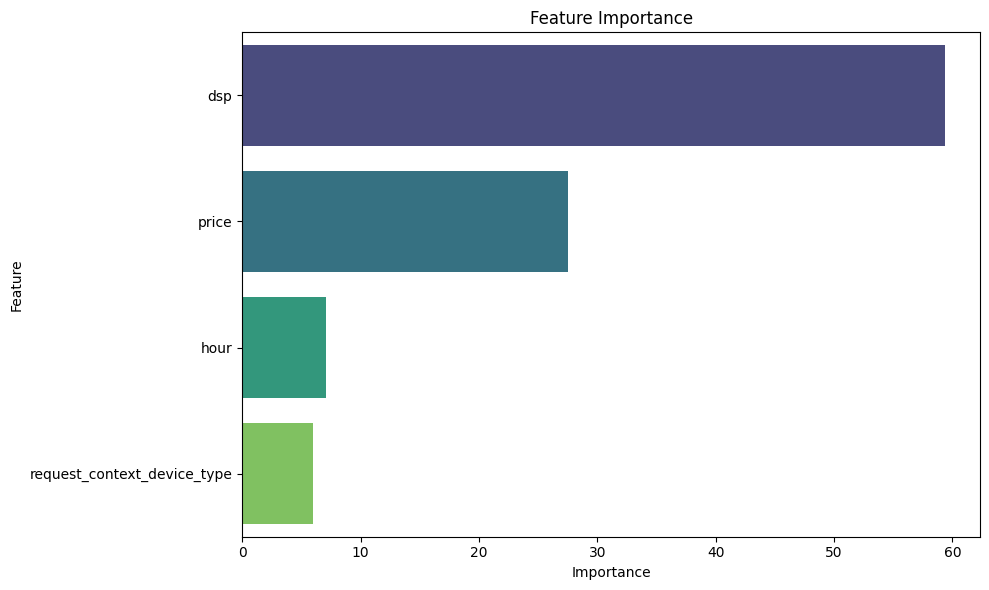

In [14]:
from matplotlib import pyplot as plt

import seaborn as sns

def plot_feature_importances(feature_importances, output_file=None):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_importances, palette='viridis', dodge=False)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file)
        print(f"Plot saved to {output_file}")
    else:
        plt.show()
plot_feature_importances(f_imp_df)

# Inference

In [16]:
X_inference = train_df[features_set]

valid_pool = Pool(data=X_inference, cat_features=features['cat'])
valid_pool

In [20]:
train_df.head()

,target,sellerClearPrice,hour,dsp,auctionBidFloorSource,os,lang,country,region,request_context_device_w,request_context_device_h,adt,contype,request_context_device_type,price,score
0,0,14.010879,0,76,ml,android,en,US,ct,1200,2000,interstitial,2,5,18.859710,0.300302
1,0,6.810017,0,80,ml,ios,en,US,mi,393,852,interstitial,2,4,9.166801,0.035363
2,0,2.499842,8,76,rollouts,android,en,NZ,bop,1080,2400,interstitial,2,4,3.453299,0.343551
3,0,3.356943,15,80,rollouts,ios,es_US,US,ks,810,1080,interstitial,2,5,4.518700,0.039060
4,0,1.487904,9,122,ml,android,en,AU,nsw,900,1440,interstitial,2,5,2.055399,0.124672


In [21]:
predicted_scores = model.predict_proba(valid_pool)
train_df['score'] = predicted_scores[:, 1]

train_df.groupby('auctionBidFloorSource').agg(mean_score = ('score', 'mean')).sort_values(by='mean_score', ascending=False)

,mean_score
auctionBidFloorSource,
user_ml,0.233834
lurl,0.167322
ml,0.136865
rollouts,0.050941
original,0.032186


In [22]:

import plotly.express as px

def plot_hist(filtered_df, metric_name='timedelta_seconds'):
    fig = px.histogram(
        filtered_df, x=metric_name, nbins=10,
        labels={metric_name: f'Title: {metric_name}'},
        title=f'Histogram of {metric_name}'
    )
    fig.show()

# Model registering

**NOTE**: for local run only, google cloud is not supported

Run mlflow container with
```shell
make run-mlflow
```

Open http://0.0.0.0:8000

Run full pipeline

```shell
make build-sagemaker;
make run-param-tuning;
```

In [26]:
import os
import sys

import pandas as pd
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from dotenv import load_dotenv

print(f'Envs loaded {load_dotenv(dotenv_path='./../.env')}')


HPO_EXPERIMENT_NAME = "catboost-params"
# mlflow.create_experiment(HPO_EXPERIMENT_NAME, artifact_location="s3://mlflow")

mlflow.set_tracking_uri("http://0.0.0.0:8000")
# mlflow.set_tracking_uri("http://mlflow_container_ui:8000")
mlflow.set_experiment(HPO_EXPERIMENT_NAME)

client = MlflowClient()
experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
# choose the best params
run = client.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.roc_auc DESC"]
)
print('all complited')

Envs loaded True
all complited


In [28]:
best_run = run[0]
best_params = best_run.data.params
best_run_id = best_run.info.run_id
print(best_params)

{'depth': '8.0', 'iterations': '350.0', 'l2_leaf_reg': '2.909954052940017', 'learning_rate': '0.12709552437597396'}


In [ ]:
model_params = {i: float(j) for  i,j in best_params.items()}

In [ ]:
from catboost import CatBoostClassifier
from IPython.display import clear_output

def train_and_save_model(train_df, config, model_path):
    print(train_df.shape[0])
    columns_subset = get_valuable_columns(train_df)
    cat_candidates = ['request_context_device_type', 'dsp', 'ssp', 'hour']
    features = {
        'cat': [col for col in cat_candidates if col in columns_subset],
        'num': ['price', ]
    }
    features_set = features['cat'] + features['num']
    X = train_df[features_set]
    y = train_df['target']
    train_pool = Pool(data=X, label=y, cat_features=features['cat'])
    model = CatBoostClassifier(**model_params)
    model.fit(train_pool)
    clear_output()
    model.save_model(model_path)
    mlflow.log_artifact(model_path, artifact_path="model")
    print('model dump finished')

train_data_path = '/Users/username/PycharmProjects/ml_for_products/data/bidmachine_task_data/test_data.csv'
model_path = '/Users/username/PycharmProjects/ml_for_products/data/bidmachine_task_data/best_model.cb'

with mlflow.start_run(run_id=best_run_id):
    train_df = pd.read_csv(train_data_path, nrows=1000)
    train_and_save_model(train_df, best_params, model_path)
    model_uri = f"runs:/{best_run_id}/model"
    mlflow.register_model(model_uri, name="rf-best-model")
print('Model loaded')

In [ ]:
with mlflow.start_run(run_id=best_run_id) as active_run:
    artifacts = client.list_artifacts(active_run.info.run_id)
    for artifact in artifacts:
        print(f"Artifact: {artifact.path}, Size: {artifact.file_size}")
    artifact_uri = mlflow.get_artifact_uri()
    print(f"Artifact URI: {artifact_uri}")
    model_uri = os.path.join(artifact_uri, "model")
    print(f"Model URI: {model_uri}")

Check model in interface

In [ ]:
import boto3

s3_client = boto3.client('s3',
        aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
        aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY'],
        endpoint_url='http://0.0.0.0:9000'
)
bucket = "mlflow"
key = model_uri.replace(f's3://mlflow/', '')
print(key)
local_path = os.path.join(root_data_dir, "downloaded_model.cb")

s3_client.download_file(bucket, os.path.join(key, 'best_model.cb'), local_path)
print(f'downloaded to {local_path}')